# Large-Cap Tech Directional Forecast Project  
*Divyanka Thakur*  
**Checkpoint A – Starter Pipeline**  

This notebook establishes the foundational pipeline for forecasting short-term directionality in large-cap tech stocks (AAPL, MSFT, NVDA).  
We include data ingestion, cleaning, feature engineering, EDA, and a toy model. Future steps will expand to regime tagging, macro overlays, and walk-forward backtesting.

In [1]:
# 1. Imports & Setup
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set_style("whitegrid")

## 2. Data Acquisition for NVIDIA  
We download NVDA’s historical prices using yfinance, ensuring an adjusted close column exists (or fallback to close).

In [10]:
ticker = "NVDA"

df = yf.download(ticker, start="2000-01-01", end="2025-01-01", auto_adjust=False)

# If `Adj Close` not present, fallback logic
if "Adj Close" not in df.columns.get_level_values(0):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(0)
    if "Close" in df.columns:
        print("Using Close as fallback for Adj Close.")
        df["Adj Close"] = df["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' present in NVDA data")

print("NVDA data shape:", df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

NVDA data shape: (6289, 6)


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2000-01-03,0.089420,0.097526,0.099219,0.091927,0.098438,300912000
2000-01-04,0.087033,0.094922,0.096094,0.090104,0.095833,300480000
2000-01-05,0.084167,0.091797,0.093750,0.090495,0.092188,188352000
2000-01-06,0.078675,0.085807,0.091797,0.082292,0.091797,120480000
2000-01-07,0.079989,0.087240,0.088151,0.084115,0.085417,71184000


In [11]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2024-12-24,140.189468,140.220001,141.899994,138.649994,140.000000,105157000
2024-12-26,139.899521,139.929993,140.850006,137.729996,139.699997,116205600
2024-12-27,136.980164,137.009995,139.020004,134.710007,138.550003,170582600
2024-12-30,137.460052,137.490005,140.270004,134.020004,134.830002,167734700
2024-12-31,134.260757,134.289993,138.070007,133.830002,138.029999,155659200


## 3. Feature Engineering for NVDA  
We compute:
- Log returns  
- Rolling vol (5- and 20-day)  
- SMAs (5, 20)  
- RSI(14)  
All based on the `Adj Close` series.

In [14]:
# Feature engineering
ret = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
vol5 = ret.rolling(window=5).std()
vol20 = ret.rolling(window=20).std()

sma5 = df["Adj Close"].rolling(window=5).mean()
sma20 = df["Adj Close"].rolling(window=20).mean()

def compute_rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window).mean()
    loss = (-delta.clip(upper=0)).rolling(window).mean()
    rs = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

rsi14 = compute_rsi(df["Adj Close"], 14)

# Combine features safely, then rename columns explicitly
feat = pd.concat([ret, vol5, vol20, sma5, sma20, rsi14], axis=1)
feat.columns = ["Return", "Vol5", "Vol20", "SMA5", "SMA20", "RSI14"]
feat = feat.dropna()
feat.head()

,Return,Vol5,Vol20,SMA5,SMA20,RSI14
Date,,,,,,
2000-02-01,0.023323,0.030460,0.033745,0.073160,0.080395,38.909810
2000-02-02,0.027627,0.034676,0.034539,0.072539,0.079768,45.524862
2000-02-03,0.015898,0.024204,0.034370,0.072969,0.079344,41.667143
2000-02-04,0.023382,0.014472,0.031614,0.074186,0.079284,38.053536
2000-02-07,-0.063610,0.038766,0.034272,0.074568,0.078920,23.727521


## EDA & Diagnostics  
Inspect feature distributions and pairwise relationships to detect multicollinearity, outliers, and potential predictive structure.

Feature summary statistics:


,Return,Vol5,Vol20,SMA5,SMA20,RSI14
count,6269.000000,6269.000000,6269.000000,6269.000000,6269.000000,6269.000000
mean,0.001204,0.030053,0.032412,8.486651,8.324140,53.723474
std,0.037291,0.022056,0.018537,22.672115,22.209744,17.413923
min,-0.434384,0.001906,0.005594,0.058849,0.065702,2.978710
25%,-0.015959,0.016033,0.020186,0.277450,0.277733,41.066681
50%,0.001372,0.024691,0.027260,0.448953,0.446363,54.146382
75%,0.017821,0.036705,0.038549,4.831955,4.774292,66.255998
max,0.353574,0.221770,0.142597,147.223782,143.104462,99.429241


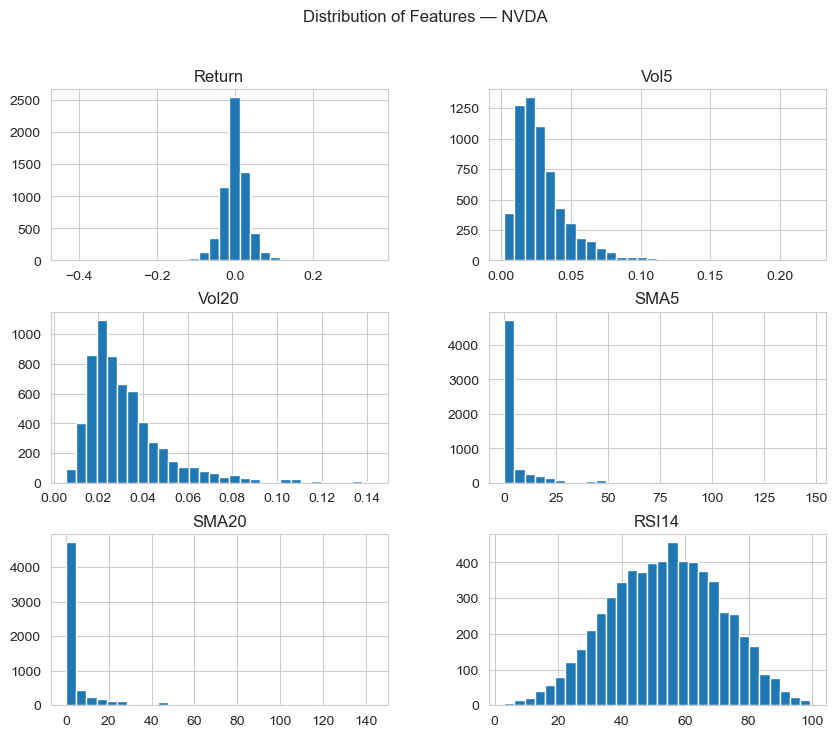

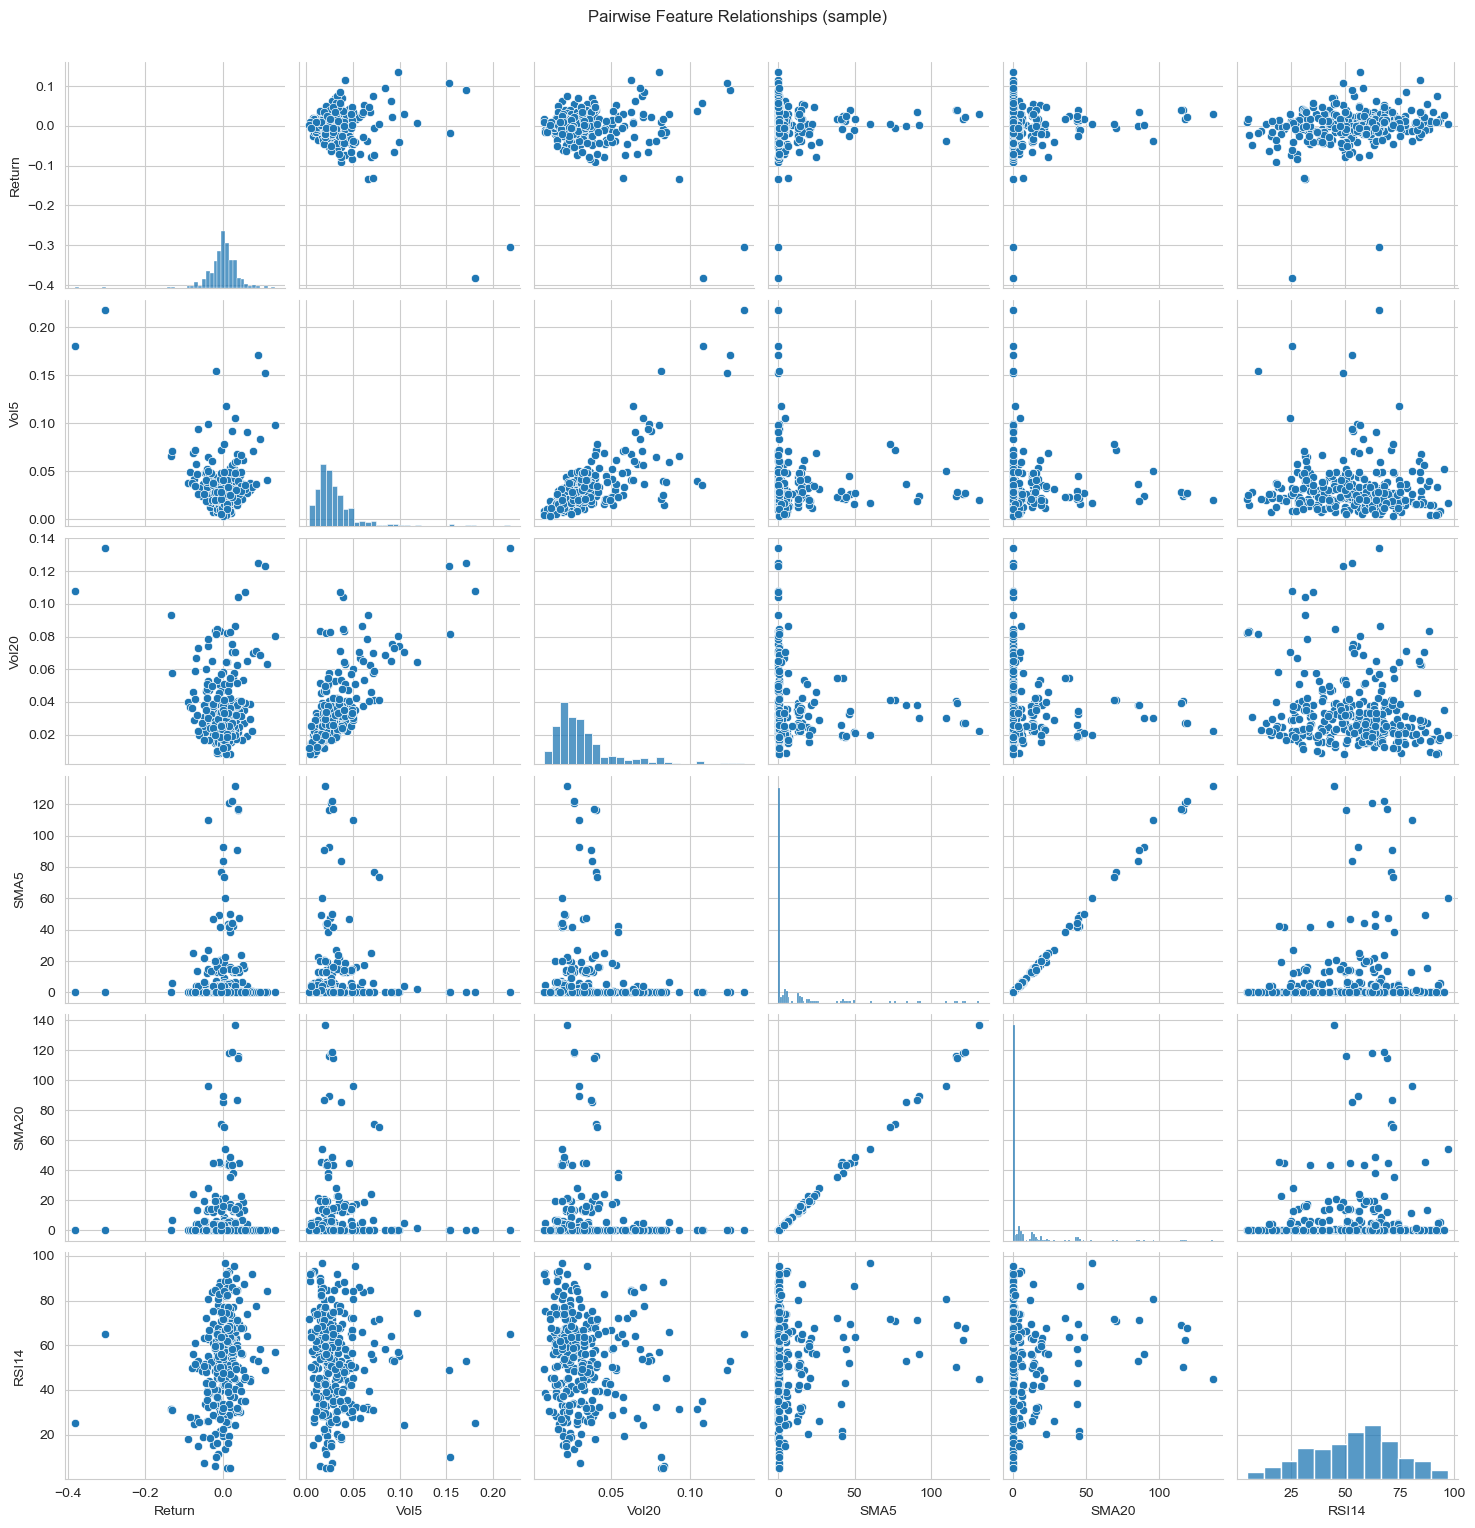

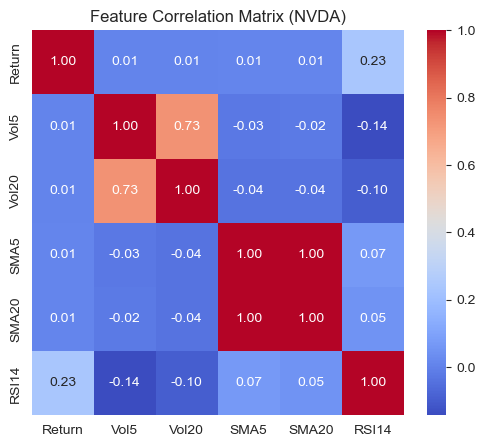

In [16]:
# Summary statistics
print("Feature summary statistics:")
display(feat.describe())

# Histograms
feat.hist(bins=30, figsize=(10, 8))
plt.suptitle("Distribution of Features — NVDA")
plt.show()

# Pairwise scatter / relationship plots
sns.pairplot(feat.sample(min(len(feat), 300)))
plt.suptitle("Pairwise Feature Relationships (sample)", y=1.02)
plt.show()

# Correlation heatmap
corr = feat.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix (NVDA)")
plt.show()

## Toy Baseline Model: Logistic Regression  
We now define a next-day directional target and train a baseline logistic regression model using a subset of the features.  
This gives us a performance benchmark to compare later with richer models and full validation.

In [17]:
# Create target: next-day up or down
feat["Target"] = (feat["Return"].shift(-1) > 0).astype(int)
feat = feat.dropna()

X = feat[["Vol5", "RSI14", "SMA5", "SMA20"]]
y = feat["Target"]

# Train-test split (chronological)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Fit logistic model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5446570972886763
Confusion matrix:
 [[  0 571]
 [  0 683]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       571
           1       0.54      1.00      0.71       683

    accuracy                           0.54      1254
   macro avg       0.27      0.50      0.35      1254
weighted avg       0.30      0.54      0.38      1254



/opt/anaconda3/envs/ra_brenna/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ra_brenna/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ra_brenna/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

## Next Steps & Roadmap  
From here, we’ll expand this prototype into the full project pipeline:

1. Incorporate event flags (e.g. earnings, FOMC) aligned to NVDA’s calendar  
2. Add macro / economic features (lagged FRED or Alpha Vantage series)  
3. Build regime tagging (e.g. via volatility tertiles or moving-average regimes)  
4. Move from train/test split → **walk-forward / expanding-window validation**  
5. Test nonlinear models (e.g. XGBoost, Random Forest)  
6. Run ablation experiments (with vs without macro/event features)  
7. Expand to multi-ticker pipeline and portfolio assembly  
8. Map model outputs to allocations / positions  
9. Perform backtests (Sharpe, drawdowns, turnover)  
10. Validate model stability over time (drift detection, regime shifts)  

Once these steps are done, we'll be ready for the full term project submission with analysis, plots, and justification.